# Similarity analysis

## similarity matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler


def cal_sim_matrix(fps, chunk_size=100):
    n = fps.shape[0]
    sim_matrix = np.zeros((n, n), dtype=np.float16)

    for i in range(0, n, chunk_size):
        for j in range(0, n, chunk_size):
            i_end = min(i + chunk_size, n)
            j_end = min(j + chunk_size, n)

            intersection = np.sum(fps[i:i_end, 0, :][:, np.newaxis, :] * fps[j:j_end, 1, :], axis=2)  # [chunk_size_i, chunk_size_j]
            sum_fps_0 = np.sum(fps[i:i_end, 0, :] ** 2, axis=1)  # [chunk_size_i]
            sum_fps_1 = np.sum(fps[j:j_end, 1, :] ** 2, axis=1)  # [chunk_size_j]

            sim_matrix[i:i_end, j:j_end] = intersection / (sum_fps_0[:, np.newaxis] + sum_fps_1 - intersection)  # [chunk_size_i, chunk_size_j]

    return sim_matrix


def get_sim_matrix(model):
    fps = np.load(f"../datasets/visualization/similarity/tg_vis/{model}.npz")['fps'].astype(np.float32)
    scaler = StandardScaler()
    fps = scaler.fit_transform(fps)
    fps = fps.reshape(-1, 6, fps.shape[1])  # [n, 6, dim]
    results = []

    for num_pa in range(1, 6):
        sim_matrix = cal_sim_matrix(fps[:, [0, num_pa], :])
        results.append(sim_matrix)

    return np.mean(results, axis=0)

sim_matrix = get_sim_matrix("fps_periogt")

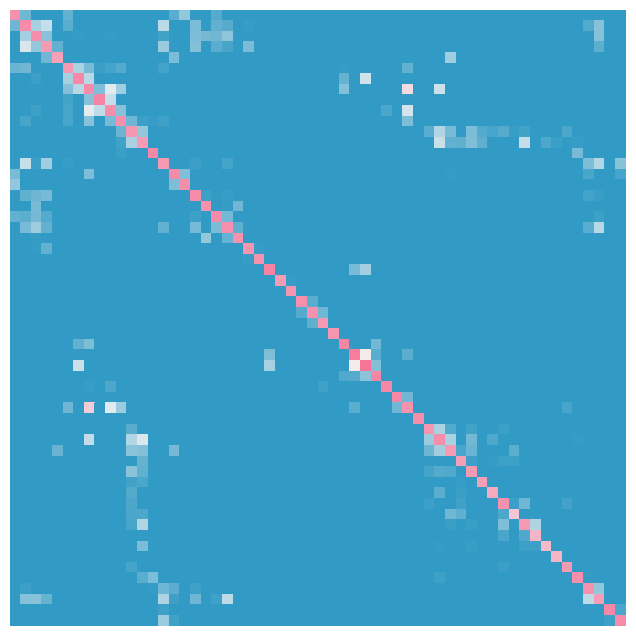

In [2]:
# Block aggregation for better visualization
downsample_factor = 100
new_size = sim_matrix.shape[0] // downsample_factor
top_n = 50
downsampled_matrix = np.zeros((new_size, new_size))

for i in range(new_size):
    for j in range(new_size):
        block = sim_matrix[i*downsample_factor:(i+1)*downsample_factor,
                j*downsample_factor:(j+1)*downsample_factor]
        top_values = np.sort(block, axis=None)[-top_n:]
        downsampled_matrix[i, j] = np.mean(top_values)

plt.figure(figsize=(10, 8), dpi=100)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True).reversed()
ax = sns.heatmap(downsampled_matrix, annot=False, cmap=cmap, cbar=False, square=True, vmin=0.5, vmax=1.0)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## similarity distribution

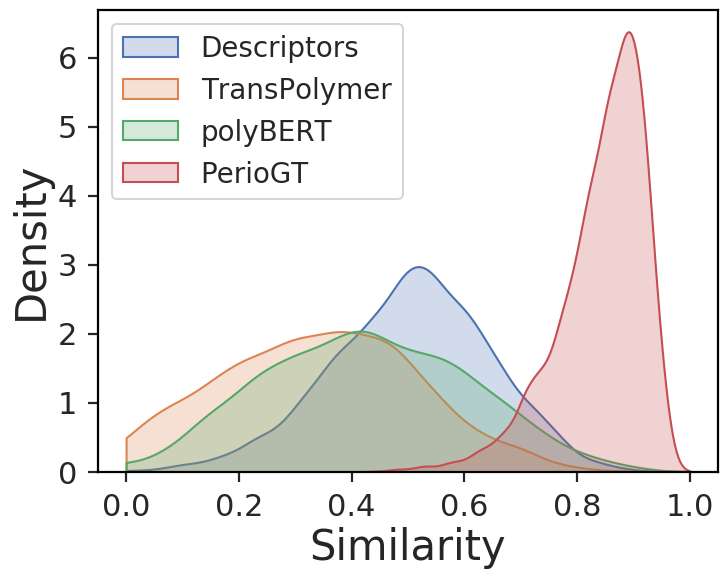

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def cal_sim(s, t):
    s = np.asarray(s)
    t = np.asarray(t)
    if (s.shape != t.shape):
        print("The size of vectors are not same!")
        return -1
    return (np.sum(s*t))/(np.sum(s**2)+np.sum(t**2)-np.sum(s*t))


def get_sim_df(model):
    if model != "md":
        fps = np.load(f"../datasets/visualization/similarity/tg_vis/fps_{model}.npz")['fps'].astype(np.float32)
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)
    else:
        fps = np.load(f"../datasets/visualization/similarity/tg_vis/fps_{model}.npz")['md'].astype(np.float32)
    fps = fps.reshape(-1, 6, fps.shape[-1])
    sim = np.zeros([fps.shape[0], 5])
    for i in range(fps.shape[0]):
        for j in range(5):
            sim[i, j] = cal_sim(fps[i, 0, :], fps[i, j+1, :])
    df = pd.DataFrame(sim)
    df.columns = ["1", "2", "3", "4", "5"]
    df['avg'] = df[["1", "2", "3", "4", "5"]].mean(axis=1)
    return df['avg']


df_md = get_sim_df("md")
df_transpolymer = get_sim_df("transpolymer")
df_polybert = get_sim_df("polybert")
df_periogt = get_sim_df("periogt")

sns.set(context="talk", style='white')
plt.figure(figsize=(8, 6))
sns.kdeplot(df_md, fill=True, label='Descriptors', clip=(0,1))
sns.kdeplot(df_transpolymer, fill=True, label='TransPolymer', clip=(0,1))
sns.kdeplot(df_polybert, fill=True, label='polyBERT', clip=(0,1))
sns.kdeplot(df_periogt, fill=True, label='PerioGT', clip=(0,1))

plt.xlim(-0.05, 1.05)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for spine in ax.spines.values():
    spine.set_linewidth(1.6)  # 设置边框线的宽度为2

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='both', direction='out', length=7, width=1.6, pad=8, labelsize=22)
plt.xlabel("Similarity", fontsize=30)
plt.ylabel("Density", fontsize=30)
plt.legend(loc="upper left", fontsize=20)
plt.show()

## DB index

In [4]:
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
import os
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def cal_db_idx(model, root_path="../datasets/visualization/similarity/tg_vis/", n_repeat=3):
    path = os.path.join(root_path, f"fps_{model}.npz")
    v = pd.read_csv(os.path.join(root_path, "tg_vis.csv"))["value"].values.tolist()

    if model == "md":
        feat = np.load(path)['md'].astype(np.float32)
    else:
        feat = np.load(path)['fps'].astype(np.float32)
    scaler = StandardScaler()
    feat = scaler.fit_transform(feat)
    results = []
    for seed in [22, 33, 44]:
        tsne = TSNE(n_components=2, random_state=seed)
        coded_fps = tsne.fit_transform(feat)
        score = davies_bouldin_score(coded_fps, v)
        results.append(score)

    return results

results_md = cal_db_idx("md")
results_transpolymer = cal_db_idx("transpolymer")
results_polybert = cal_db_idx("polybert")
results_periogt = cal_db_idx("periogt")

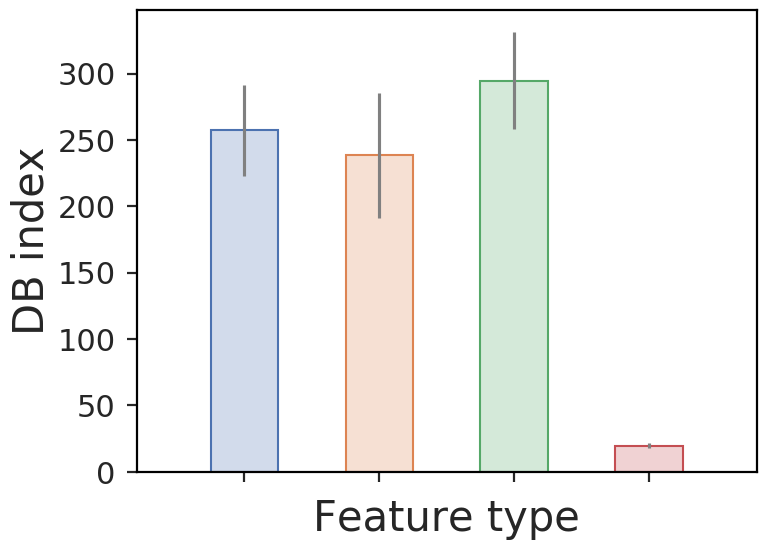

In [5]:
models = ["md", "transpolymer", "polybert", "periogt"]
results = [results_md, results_transpolymer, results_polybert, results_periogt]

df = pd.DataFrame({
    "Model": np.repeat(models, len(results_md)),
    "Davies-Bouldin Score": np.concatenate(results)
})
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)

sns.set(context="talk", style='white')
plt.figure(figsize=(8, 6))

edge_colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]
fill_colors = ["#D2DBEB", "#F6E0D3", "#D4E9D9", "#F0D2D3"]

mean_scores = df.groupby("Model")["Davies-Bouldin Score"].mean()
std_scores = df.groupby("Model")["Davies-Bouldin Score"].std()

bars = plt.bar(mean_scores.index, mean_scores.values, yerr=std_scores.values,
               color=fill_colors, edgecolor=edge_colors, width=0.5, ecolor='grey')

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='both', direction='out', length=7, width=1.6, pad=8, labelsize=22)
plt.xlabel("Feature type", fontsize=30)
plt.ylabel("DB index", fontsize=30)
ax.set_xticklabels([])
plt.xlim(-0.8, len(fill_colors)-0.2)

plt.show()

## KNN classification

In [6]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


def prepare_knn_dataset(model, dataset="tg_vis", root_path="../datasets/visualization/similarity/"):
    SPLIT_TO_ID = {'train': 0, 'test': 1}
    split_path = os.path.join(root_path, f"{dataset}/splits/split.pkl")
    with open(split_path, 'rb') as f:
        split_idx = pickle.load(f)
    train_idx = split_idx[SPLIT_TO_ID["train"]]
    test_idx = split_idx[SPLIT_TO_ID["test"]]

    df = pd.read_csv(os.path.join(root_path, f"{dataset}/{dataset}.csv"))
    y = df["value"].values
    y_train, y_test = y[train_idx], y[test_idx]

    path = os.path.join(root_path, f"{dataset}/fps_{model}.npz")
    if model == 'md':
        feat = np.load(path)['md'].astype(np.float32)
    else:
        feat = np.load(path)['fps'].astype(np.float32)

    x_train, x_test = feat[train_idx], feat[test_idx]
    scaler = StandardScaler()
    scaler.fit(x_train)

    return scaler.transform(x_train), scaler.transform(x_test), y_train, y_test


def train_knn_cls(model, k=5):
    x_train, x_test, y_train, y_test = prepare_knn_dataset(model)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    return acc

values = [train_knn_cls("md"), train_knn_cls("transpolymer"), train_knn_cls("polybert"), train_knn_cls("periogt")]

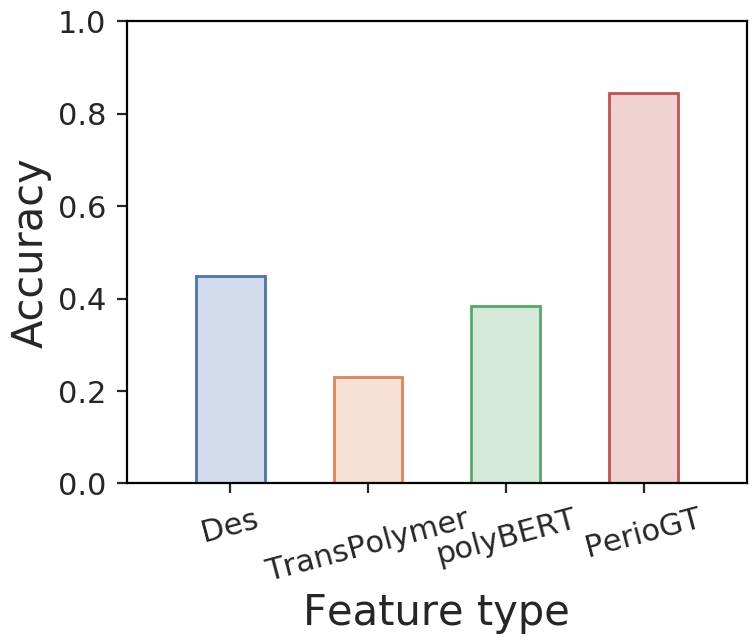

In [7]:
sns.set(context="talk", style='white')
plt.figure(figsize=(8, 6))

edge_colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]
colors = ["#D2DBEB", "#F6E0D3", "#D4E9D9", "#F0D2D3"]
plt.bar(["Des", "TransPolymer", "polyBERT", "PerioGT"], values, color=colors, edgecolor=edge_colors, linewidth=2, width=0.5)
plt.xticks(rotation=15)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='both', direction='out', length=7, width=1.6, pad=8, labelsize=22)
plt.xlabel("Feature type", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.ylim(0, 1)
plt.xlim(-0.75, len(colors) - 0.25)

plt.show()

## Sim with n

In [8]:
def cal_similarity(model, root_path="../datasets/visualization/similarity/tg_vis"):
    file_path = os.path.join(root_path, "pa_with_n", f"fps_{model}.npz")
    if model == "md":
        fps = np.load(file_path)['md'].astype(np.float32)
    else:
        fps = np.load(file_path)['fps'].astype(np.float32)

    scaler = StandardScaler()
    fps = scaler.fit_transform(fps)
    fps_periogt = fps.reshape(-1, 6, fps.shape[-1])
    results = []
    for i in range(fps_periogt.shape[0]):
        lst = []
        for j in range(1, 6):
            lst.append(cal_sim(fps_periogt[i, 0, :], fps_periogt[i, j, :]))
        results.append(lst)

    results_df = pd.DataFrame(results)
    results_df.columns = ["1", "2", "3", "4", "5"]
    return results_df.melt(var_name='x', value_name='y')


df_md = cal_similarity("md")
df_transpolymer = cal_similarity("transpolymer")
df_polybert = cal_similarity("polybert")
df_periogt = cal_similarity("periogt")

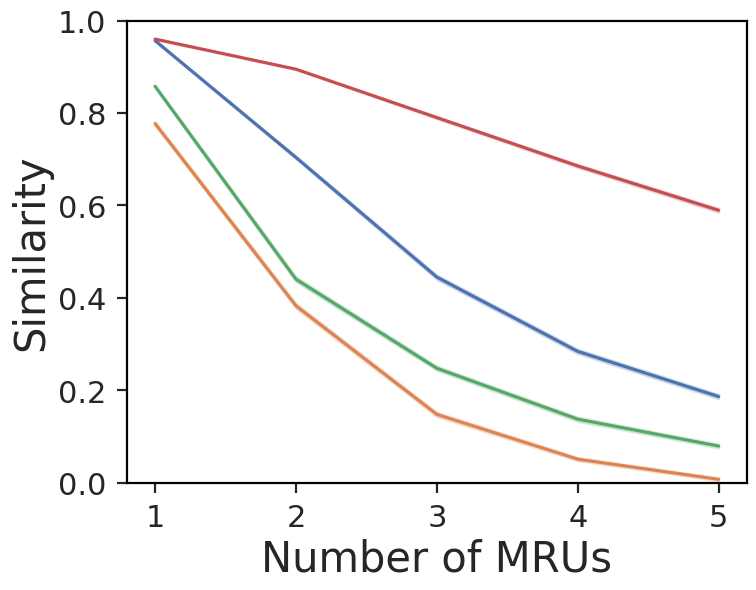

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(context="talk", style='white')
plt.figure(figsize=(8, 6))

sns.lineplot(data=df_md, x='x', y='y', errorbar=("ci", 95))
sns.lineplot(data=df_transpolymer, x='x', y='y', errorbar=("ci", 95))
sns.lineplot(data=df_polybert, x='x', y='y', errorbar=("ci", 95))
sns.lineplot(data=df_periogt, x='x', y='y', errorbar=("ci", 95))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='both', direction='out', length=7, width=1.6, pad=8, labelsize=22)
plt.xlabel("Number of MRUs", fontsize=30)
plt.ylabel("Similarity", fontsize=30)
plt.ylim(0, 1)
plt.show()

## Attribute alignment

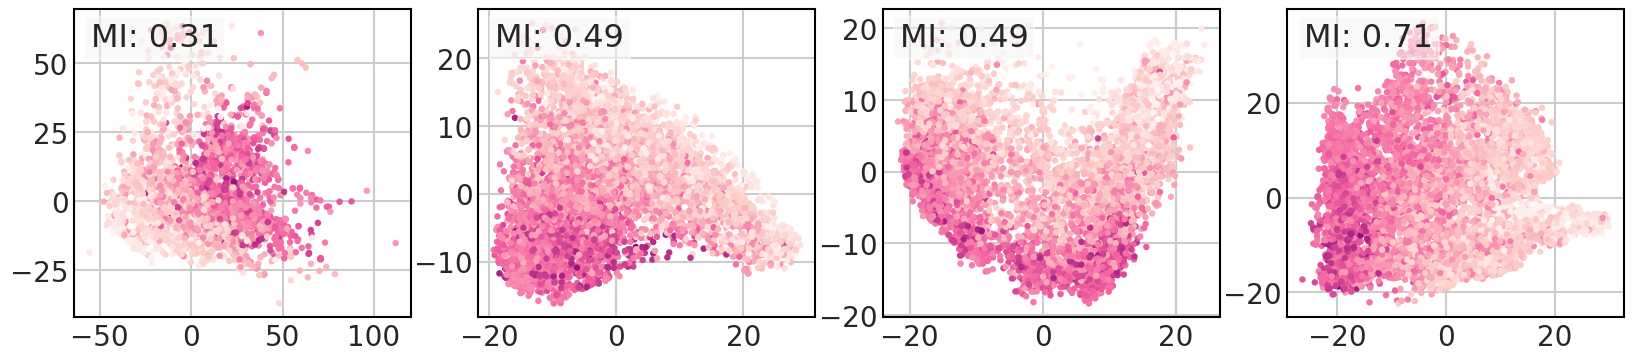

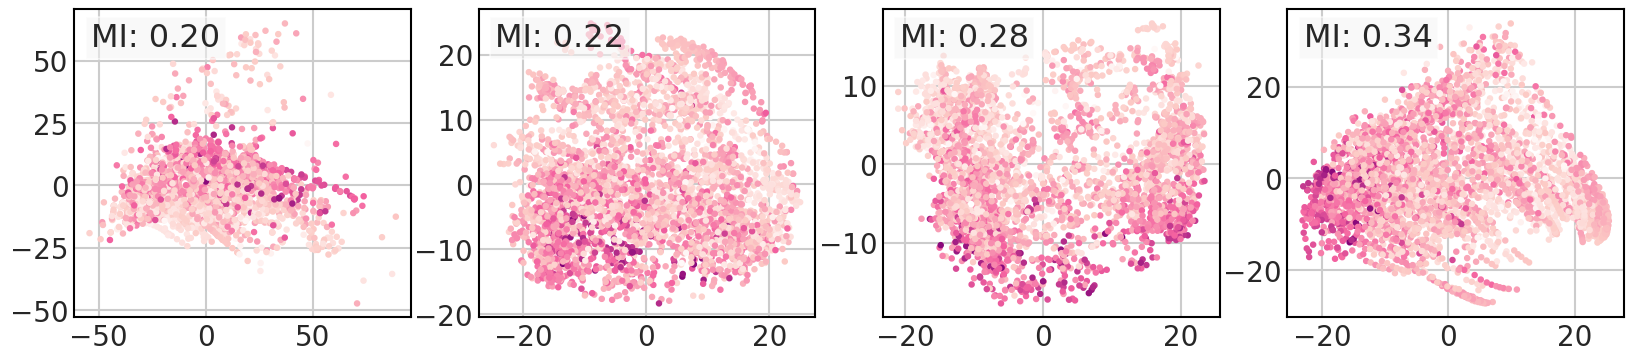

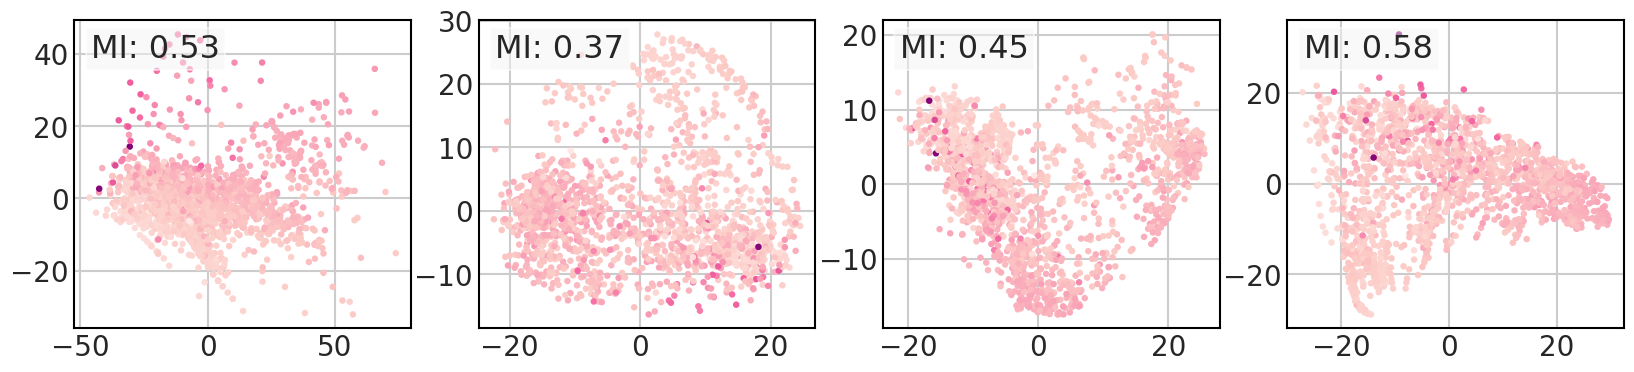

In [10]:
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from sklearn.feature_selection import mutual_info_regression
from sklearn.manifold import TSNE
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


root_path = "../datasets/visualization/attribute_align/"
for dataset in ["tg", "egb", "egc"]:
    models = ["md", "transpolymer", "polybert", "periogt"]
    coded_fps_lst = []
    for model in models:
        if model != "md":
            fps = np.load(os.path.join(root_path, dataset, f"fps_{model}.npz"))['fps'].astype(np.float32)
        else:
            fps = np.load(os.path.join(root_path, dataset, f"fps_{model}.npz"))['md'].astype(np.float32)
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)
        pca = PCA(n_components=2)
        coded_fps = pca.fit_transform(fps)
        coded_fps_lst.append(coded_fps)

    v = pd.read_csv(os.path.join(root_path, dataset, f"{dataset}.csv"))["value"].values
    sns.set(context="talk", style="whitegrid")
    fig, axn = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    cdict = ["white", '#FCCAC5', '#F462A0','#810178']
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cdict)

    for ax, coded_fp in zip(axn, coded_fps_lst):
        result = mutual_info_regression(coded_fp[:, :2], v)
        result = result.sum()

        ax.text(0.05, 0.88, f"MI: {result:.2f}", fontsize=23, transform=ax.transAxes,
                bbox=dict(facecolor="whitesmoke", alpha=0.5))

        x = coded_fp[:, 0]
        y = v
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)

        scatter = ax.scatter(coded_fp[:, 0], coded_fp[:, 1], c=y, s=100, cmap=cmap, edgecolor='face')
        ax.tick_params(axis='both', labelsize=20, pad=-5)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)

    plt.subplots_adjust(left=None, right=None, top=None, bottom=None, wspace=0.2)
    plt.show()

## Structural alignment

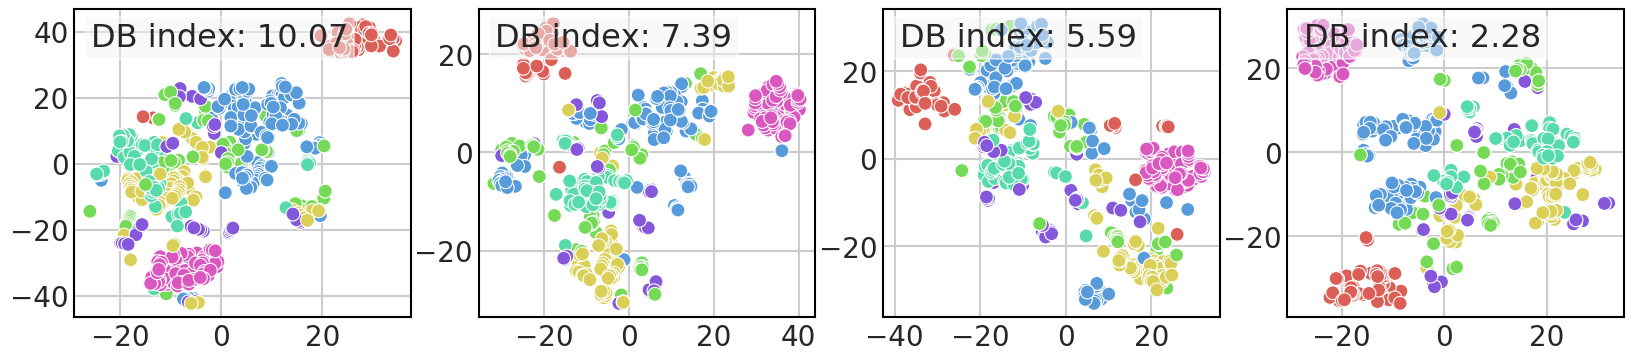

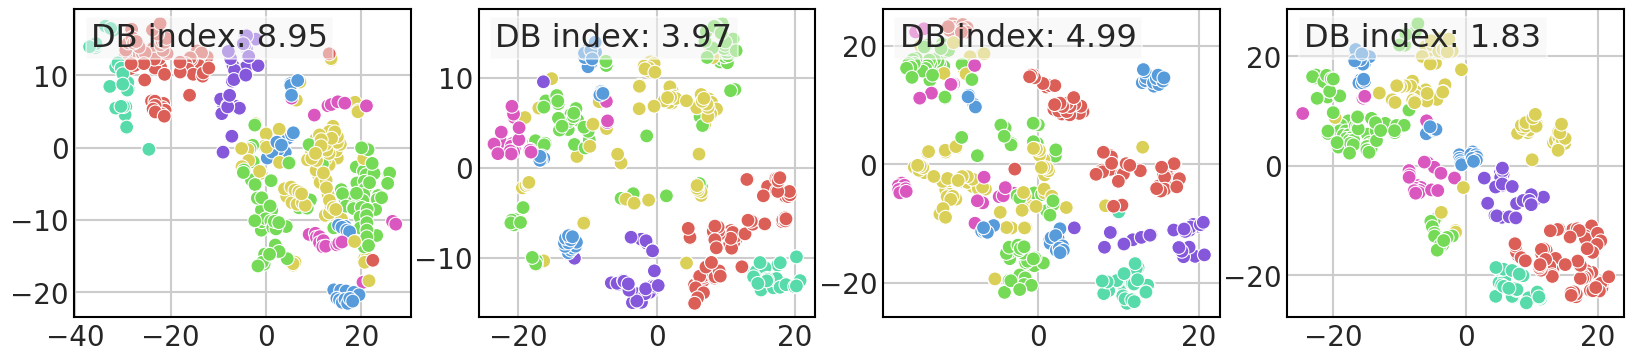

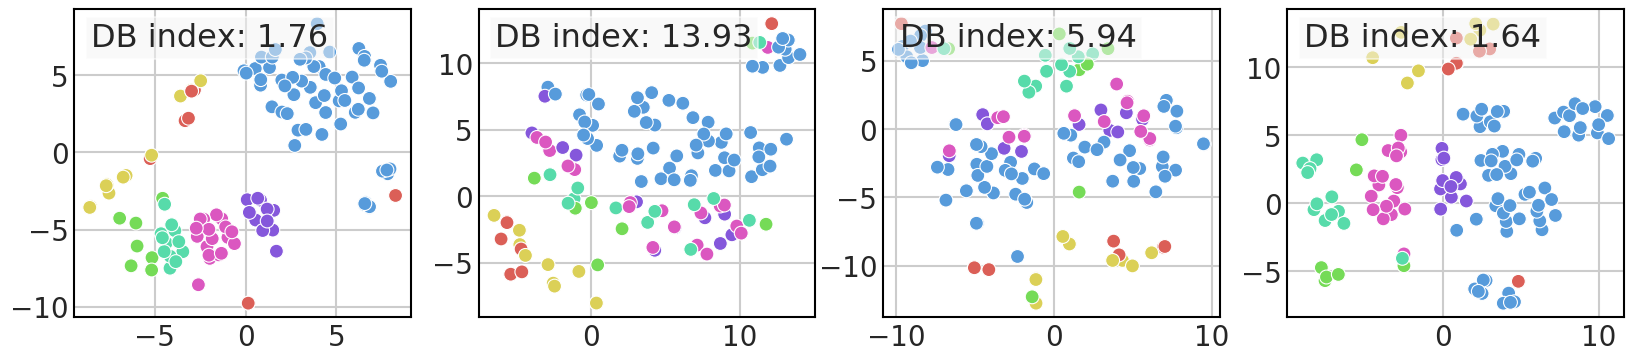

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def cal_db_index(dataset, model, name, use_idx, v):
    fps = np.load(f"../datasets/visualization/structural_align/{dataset}/fps_{model}.npz")[name].astype(np.float32)[use_idx]
    scaler = StandardScaler()
    scaler.fit(fps)
    fps = scaler.transform(fps)
    tsne = TSNE(n_components=2, random_state=22)
    coded_fps = tsne.fit_transform(fps)
    score = davies_bouldin_score(coded_fps, v)
    return coded_fps, score

for dataset in ["tg", "mt", "egb"]:
    models = ['md', 'transpolymer', 'polybert', 'periogt']
    names = ['md', 'fps', 'fps', 'fps']

    df = pd.read_csv(f'../datasets/visualization/structural_align/{dataset}/scaffold.csv')
    scaffold_counts = df['scaffold'].value_counts()
    top_scaffolds = scaffold_counts.iloc[2:9].index  # Samples with empty scaffold are excluded
    use_idx = df[df['scaffold'].isin(top_scaffolds)].index.tolist()
    df_top = df.iloc[use_idx]

    coded_fps = []
    db_indics = []
    for model, name in zip(models, names):
        coded_fp, db_index = cal_db_index(dataset=dataset, model=model, name=name, use_idx=use_idx, v=df_top["scaffold"])
        coded_fps.append(coded_fp)
        db_indics.append(db_index)

    sns.set(context="talk", style="whitegrid")
    fig, axn = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    flag = 1
    for ax, coded_fp, db_index in zip(axn, coded_fps, db_indics):
        ax.text(0.05, 0.88, f"DB index: {db_index:.2f}", fontsize=23, transform=ax.transAxes, bbox=dict(facecolor="whitesmoke", alpha=0.5))
        if flag == 1:
            sns.scatterplot(ax=ax, x=coded_fp[:, 0], y=coded_fp[:, 1], hue=df_top['scaffold'], palette=sns.color_palette("hls", 7), s=100, legend=False)
        else:
            sns.scatterplot(ax=ax, x=coded_fp[:, 0], y=coded_fp[:, 1], hue=df_top['scaffold'],
                            palette=sns.color_palette("hls", 7), s=100, legend=False)
        ax.tick_params(axis='both', labelsize=20, pad=-5)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
        flag += 1

    plt.subplots_adjust(left=None, right=None, top=None, bottom=None, wspace=0.2)
    plt.show()

## KNN

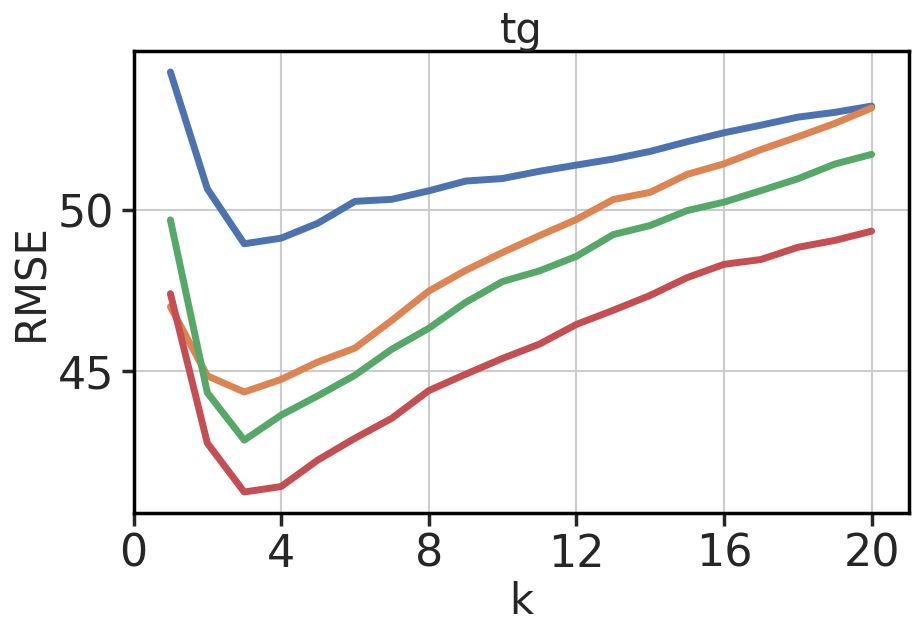

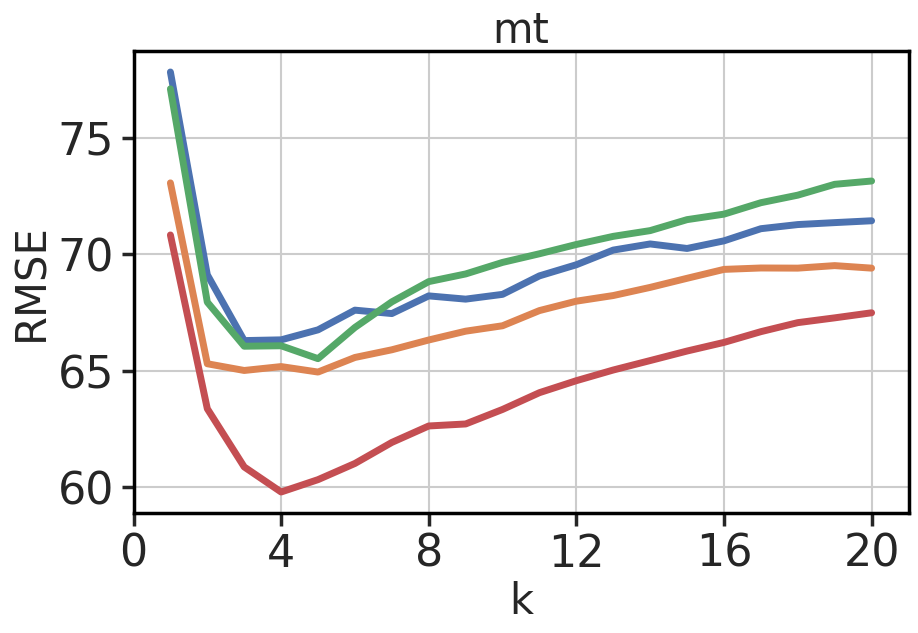

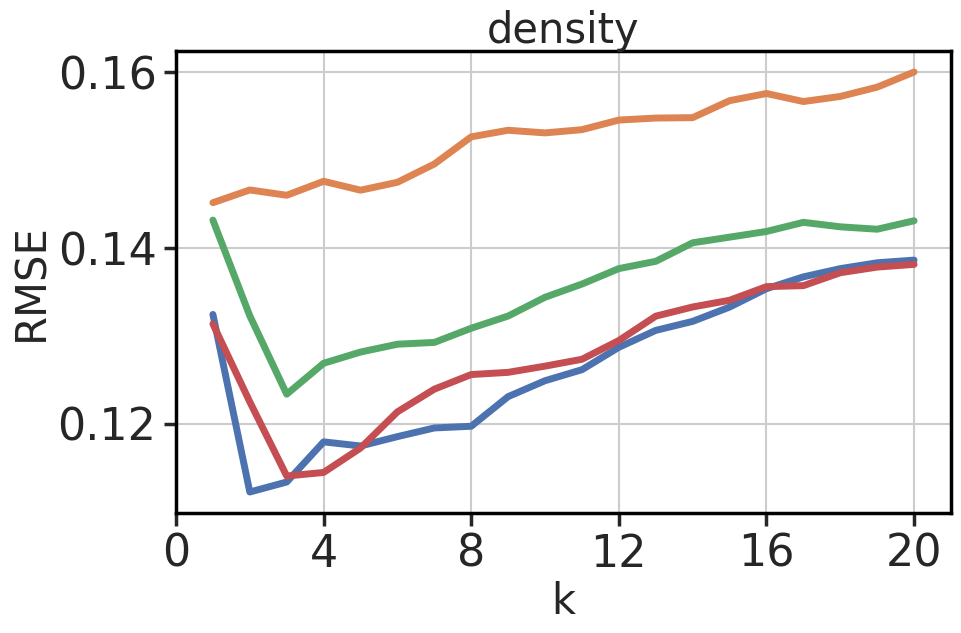

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import pickle
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def train(dataset, model, k, seed, root_path="../datasets/visualization/knn"):
    x_train, x_test, y_train, y_test = get_train_regressor_data(
        dataset=dataset,
        model=model,
        seed=seed,
        root_path=root_path
    )

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)

    y_pred = knn.predict(x_test)
    y_true = y_test
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return [model, rmse, r2, k, seed]


def get_train_regressor_data(dataset, model, seed, root_path):
    df = pd.read_csv(os.path.join(root_path, f"{dataset}/{dataset}.csv"))
    indices = np.arange(len(df))
    np.random.seed(seed)
    np.random.shuffle(indices)
    num_test = int(len(df) * 0.1)
    train_idx = indices[num_test:]
    test_idx = indices[:num_test]
    y = df["value"].values
    y_train, y_test = y[train_idx], y[test_idx]

    path = os.path.join(root_path, f"{dataset}/fps_{model}.npz")

    if model == 'md':
        fps = np.load(path)['md'].astype(np.float32)
        x_train, x_test = fps[train_idx], fps[test_idx]
        scaler = StandardScaler()
        scaler.fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test), y_train, y_test
    else:
        fps = np.load(path)['fps'].astype(np.float32)
        x_train, x_test = fps[train_idx], fps[test_idx]
        return x_train, x_test, y_train, y_test

for dataset in ["tg", "mt", "density"]:
    models = ["md", "transpolymer", "polybert", "periogt"]
    seeds = [22, 33, 44]
    k_list = list(range(1, 21))
    results = []
    for model in models:
        for k in k_list:
            for seed in seeds:
                data = train(dataset, model, k, seed)
                results.append(data)
    df = pd.DataFrame(results)
    df.columns = ["model", "RMSE", "R2", "k", "seed"]

    sns.set(context="talk", style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(df, x="k", y="RMSE", hue="model", errorbar=None, legend=False, linewidth=5)
    plt.xlim(0, 21)
    ax = plt.gca()
    ax.tick_params(axis='both', labelsize=32, pad=5, width=2.5)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xticks(range(0, 22))
    # plt.yticks(range(60, 80))
    # ax.set_yticks(range(int(df['RMSE'].min())+5, int(df['RMSE'].max()) + 2, 5))

    plt.xlabel("k", fontsize=30)
    plt.ylabel("RMSE", fontsize=30)
    plt.title(f"{dataset}", fontsize=30)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(True)
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(True)

    x_major_locator = MultipleLocator(4)
    ax.xaxis.set_major_locator(x_major_locator)
    # y_major_locator = MultipleLocator(5)
    # ax.yaxis.set_major_locator(y_major_locator)
    plt.show()

## Uniformity

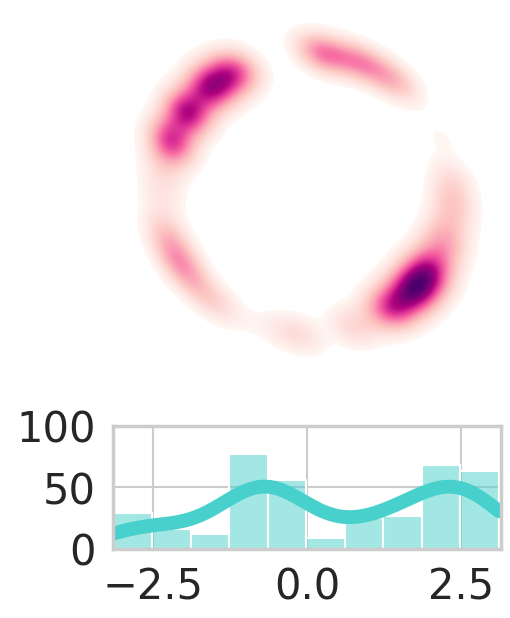

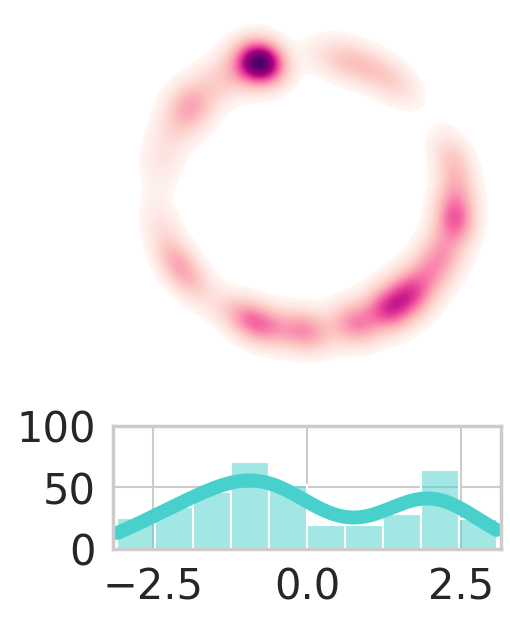

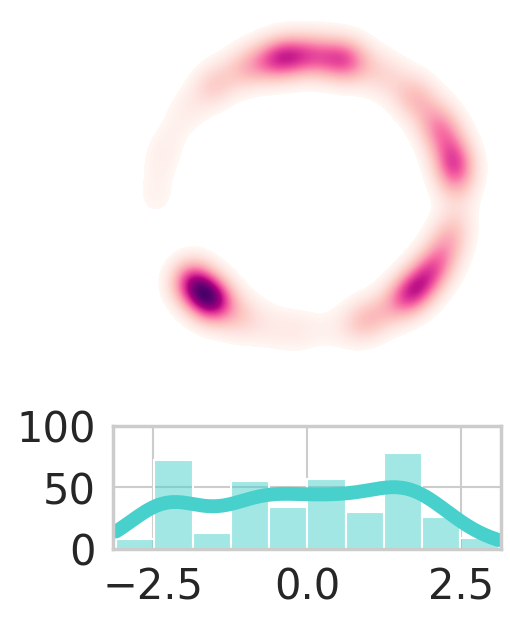

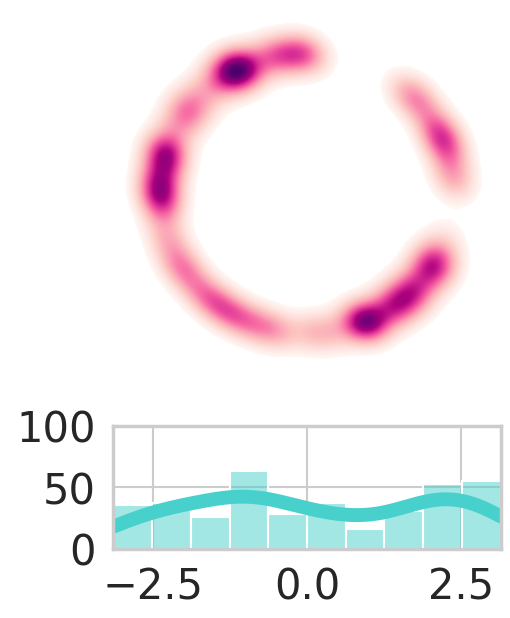

In [13]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


models = ['md', 'transpolymer', 'polybert', 'periogt']
for model in models:
    root_path = "../datasets/visualization/uniformity/"
    if model != "md":
        fps = np.load(os.path.join(root_path, f"fps_{model}.npz"))['fps'].astype(np.float32)
    else:
        fps = np.load(os.path.join(root_path, f"fps_{model}.npz"))['md'].astype(np.float32)
    scaler = StandardScaler()
    fps = scaler.fit_transform(fps)
    tsne = TSNE(n_components=2, random_state=22)
    coded_fps = tsne.fit_transform(fps)
    normalizer = Normalizer(norm='l2').fit(coded_fps)
    norm_fps = normalizer.transform(coded_fps)

    z = gaussian_kde(norm_fps.T)(norm_fps.T)
    plt.figure(figsize=(5, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])

    sns.kdeplot(x=norm_fps[:, 0], y=norm_fps[:, 1], fill=True, cmap="RdPu", levels=500, bw_adjust=0.4)

    ax0.spines['bottom'].set_linewidth(2.5)
    ax0.spines['left'].set_linewidth(2.5)
    ax0.spines['top'].set_linewidth(2.5)
    ax0.spines['right'].set_linewidth(2.5)
    ax0.set_axis_off()

    plt.xticks(size=30)
    plt.yticks(size=30)

    ax1 = plt.subplot(gs[1])
    angles = np.arctan2(norm_fps[:, 1], norm_fps[:, 0])
    plt.xlim(-3.14, 3.14)
    plt.ylim(0, 100)
    y_major_locator = MultipleLocator(50)
    x_major_locator = MultipleLocator(2.5)
    ax1.yaxis.set_major_locator(y_major_locator)
    ax1.xaxis.set_major_locator(x_major_locator)
    plt.xticks(size=30)
    plt.yticks(size=30)
    plt.ylabel(" ", fontdict={'size': 1})

    ax1.spines['bottom'].set_linewidth(2.5)
    ax1.spines['left'].set_linewidth(2.5)
    ax1.spines['top'].set_linewidth(2.5)
    ax1.spines['right'].set_linewidth(2.5)

    plt.tick_params(axis="both", which="major", direction="out", width=2.5, length=7.5, pad=5)
    sns.histplot(angles, color="mediumturquoise", kde=True, line_kws={"lw": 10}, kde_kws={'bw_adjust': 1.2})
    plt.show()